In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import optuna

data = pd.read_csv('/Users/Hsiao-ping.ni/ASU Dropbox/Hsiao-Ping Ni/PhD/Data/4th paper- Chiller/VAE_Anomaly_Detection_Results.csv', encoding='unicode_escape')
data

,ï»¿Discharge Temp (F),Input % full load amps (Motor) (%),Condenser liq temp IN (F),Condenser liq temp OUT (F),Chilled liq temp IN (F),Chilled liq temp OUT (F),Condenser saturation (F),Evaporator saturation (F),Evaporator pressure (PSIG),Condenser pressure (PSIG),Oil sump temp (F),Oil pressure (PSIG),Anomaly
0,115.9,62.7,92.4,97.4,46.2,40.5,98.3,39.4,34.5,120.6,127.2,35.17,1
1,113.4,46.0,89.9,96.4,46.3,40.5,96.8,39.5,34.6,117.6,133.2,34.92,0
2,116.2,62.2,92.4,97.2,40.3,40.5,98.4,39.4,34.4,120.7,127.4,35.14,1
3,114.7,44.7,90.4,96.4,46.2,40.4,96.8,39.6,34.6,117.4,133.3,35.07,0
4,115.7,63.8,92.2,97.2,46.2,40.5,98.3,39.5,34.5,120.6,127.2,34.81,0
5,113.5,46.6,90.2,96.5,46.3,40.5,97.0,39.5,34.6,117.9,133.2,34.90,0
6,114.9,64.8,91.2,96.5,46.9,40.6,97.7,39.3,34.3,119.3,127.3,34.07,1
7,112.7,47.9,89.4,95.9,47.1,40.5,96.5,39.4,34.5,117.0,133.4,35.82,0
8,113.8,67.1,90.6,96.2,47.6,40.5,97.5,39.2,34.4,119.0,127.6,35.19,0
9,111.7,49.0,88.9,95.6,47.6,40.5,96.0,39.3,34.4,115.9,133.3,34.87,0


In [3]:
# Load and preprocess the data
data = pd.read_csv('/Users/Hsiao-ping.ni/ASU Dropbox/Hsiao-Ping Ni/PhD/Data/4th paper- Chiller/VAE_Anomaly_Detection_Results.csv', encoding='unicode_escape')
data = data[['ï»¿Discharge Temp (F)', 'Input % full load amps (Motor) (%)', 'Condenser liq temp IN (F)',
             'Condenser liq temp OUT (F)', 'Chilled liq temp IN (F)', 'Chilled liq temp OUT (F)',
             'Condenser saturation (F)', 'Evaporator saturation (F)', 'Evaporator pressure (PSIG)',
             'Condenser pressure (PSIG)', 'Oil sump temp (F)', 'Oil pressure (PSIG)', 'Anomaly']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['Anomaly']))  # Normalize only the features

# Define the Sampling layer for VAE
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

# Define VAE architecture
def build_vae(input_dim, hidden_dims, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,))
    x = inputs
    for dim in hidden_dims:
        x = Dense(dim, activation='relu')(x)
    mean = Dense(latent_dim)(x)
    log_var = Dense(latent_dim)(x)
    z = Sampling()([mean, log_var])
    encoder = Model(inputs, [mean, log_var, z], name="encoder")
    
    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = latent_inputs
    for dim in reversed(hidden_dims):
        x = Dense(dim, activation='relu')(x)
    outputs = Dense(input_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name="decoder")
    
    # VAE Model
    reconstructed = decoder(encoder(inputs)[2])
    vae = Model(inputs, reconstructed, name="vae")
    
    # VAE Loss
    reconstruction_loss = mse(inputs, reconstructed) * input_dim
    kl_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return vae, encoder, decoder

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1
val_losses = []

for train_index, val_index in kf.split(data_scaled):
    print(f"\nFold {fold}:")
    X_train_fold, X_val_fold = data_scaled[train_index], data_scaled[val_index]

    # Define VAE architecture for each fold
    vae, encoder, decoder = build_vae(input_dim=data_scaled.shape[1], hidden_dims=[64, 32], latent_dim=8)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    
    # Train the VAE on this fold
    history = vae.fit(X_train_fold, X_train_fold, validation_data=(X_val_fold, X_val_fold), 
                      epochs=100, batch_size=32, verbose=1)
    
    # Save the best validation loss
    best_val_loss = min(history.history['val_loss'])
    val_losses.append(best_val_loss)
    print(f"Best validation loss for fold {fold}: {best_val_loss}")
    fold += 1

# Report the average validation loss
avg_val_loss = np.mean(val_losses)
print(f"\nAverage validation loss across all folds: {avg_val_loss}")

# Final training on the full dataset
vae, encoder, decoder = build_vae(input_dim=data_scaled.shape[1], hidden_dims=[64, 32], latent_dim=8)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
history = vae.fit(data_scaled, data_scaled, epochs=100, batch_size=32, verbose=1)

# Augment normal data (generate 1250 normal samples)
normal_data_scaled = data_scaled[data['Anomaly'] == 0]
desired_normal_size = 1250
augmented_normal_data_list = []
while len(augmented_normal_data_list) < desired_normal_size:
    new_samples = vae.predict(normal_data_scaled)
    augmented_normal_data_list.extend(new_samples)

augmented_normal_data = pd.DataFrame(augmented_normal_data_list[:desired_normal_size], columns=data.columns[:-1])
augmented_normal_data['label_column'] = 0  # Label for normal data

# Augment anomalies (generate 1250 anomaly samples)
anomalies_scaled = data_scaled[data['Anomaly'] == 1]
desired_anomaly_size = 1250
augmented_anomaly_data_list = []
while len(augmented_anomaly_data_list) < desired_anomaly_size:
    new_samples = vae.predict(anomalies_scaled)
    augmented_anomaly_data_list.extend(new_samples)

augmented_anomaly_data = pd.DataFrame(augmented_anomaly_data_list[:desired_anomaly_size], columns=data.columns[:-1])
augmented_anomaly_data['label_column'] = 1  # Label for anomalies

# Combine the augmented data and shuffle
augmented_data = pd.concat([augmented_normal_data, augmented_anomaly_data], axis=0)
augmented_data = shuffle(augmented_data, random_state=42)

# Save the augmented data
output_path = '/Users/Hsiao-ping.ni/ASU Dropbox/Hsiao-Ping Ni/PhD/Data/4th paper- Chiller/VAE_Balanced_Augmented_Chiller_Data.xlsx'
augmented_data.to_excel(output_path, index=False)
print(f"Augmented balanced data saved to {output_path}.")



Fold 1:
Epoch 1/100
2/2 [==============================] - 1s 190ms/step - loss: 1.6163 - val_loss: 1.7308
Epoch 2/100
2/2 [==============================] - 0s 28ms/step - loss: 1.4841 - val_loss: 1.6668
Epoch 3/100
2/2 [==============================] - 0s 27ms/step - loss: 1.3319 - val_loss: 1.4849
Epoch 4/100
2/2 [==============================] - 0s 25ms/step - loss: 1.2476 - val_loss: 1.3892
Epoch 5/100
2/2 [==============================] - 0s 33ms/step - loss: 1.1645 - val_loss: 1.3738
Epoch 6/100
2/2 [==============================] - 0s 27ms/step - loss: 1.0821 - val_loss: 1.2870
Epoch 7/100
2/2 [==============================] - 0s 27ms/step - loss: 1.0609 - val_loss: 1.2046
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 1.0335 - val_loss: 1.1854
Epoch 9/100
2/2 [==============================] - 0s 24ms/step - loss: 1.0351 - val_loss: 1.3348
Epoch 10/100
2/2 [==============================] - 0s 25ms/step - loss: 0.9817 - val_loss: 1.2271
Epoch 11/

2/2 [==============================] - 0s 26ms/step - loss: 0.8514 - val_loss: 0.8613
Epoch 66/100
2/2 [==============================] - 0s 30ms/step - loss: 0.8956 - val_loss: 0.9397
Epoch 67/100
2/2 [==============================] - 0s 29ms/step - loss: 0.9451 - val_loss: 0.8461
Epoch 68/100
2/2 [==============================] - 0s 27ms/step - loss: 0.8853 - val_loss: 0.7785
Epoch 69/100
2/2 [==============================] - 0s 26ms/step - loss: 0.9083 - val_loss: 0.8185
Epoch 70/100
2/2 [==============================] - 0s 29ms/step - loss: 0.9270 - val_loss: 0.8347
Epoch 71/100
2/2 [==============================] - 0s 26ms/step - loss: 0.9035 - val_loss: 0.8972
Epoch 72/100
2/2 [==============================] - 0s 26ms/step - loss: 0.8683 - val_loss: 0.7594
Epoch 73/100
2/2 [==============================] - 0s 31ms/step - loss: 0.8768 - val_loss: 0.9070
Epoch 74/100
2/2 [==============================] - 0s 28ms/step - loss: 0.9069 - val_loss: 0.8039
Epoch 75/100
2/2 [=====

2/2 [==============================] - 0s 23ms/step - loss: 0.8784 - val_loss: 0.7556
Epoch 30/100
2/2 [==============================] - 0s 23ms/step - loss: 0.8821 - val_loss: 0.7794
Epoch 31/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9108 - val_loss: 0.8174
Epoch 32/100
2/2 [==============================] - 0s 24ms/step - loss: 0.8709 - val_loss: 0.8220
Epoch 33/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8650 - val_loss: 0.9717
Epoch 34/100
2/2 [==============================] - 0s 26ms/step - loss: 0.9387 - val_loss: 0.8595
Epoch 35/100
2/2 [==============================] - 0s 28ms/step - loss: 0.8912 - val_loss: 0.8362
Epoch 36/100
2/2 [==============================] - 0s 27ms/step - loss: 0.8931 - val_loss: 0.8448
Epoch 37/100
2/2 [==============================] - 0s 26ms/step - loss: 0.9121 - val_loss: 0.8437
Epoch 38/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8741 - val_loss: 0.8353
Epoch 39/100
2/2 [=====

Epoch 94/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9843 - val_loss: 0.7442
Epoch 95/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9478 - val_loss: 0.6914
Epoch 96/100
2/2 [==============================] - 0s 23ms/step - loss: 0.9276 - val_loss: 0.6975
Epoch 97/100
2/2 [==============================] - 0s 24ms/step - loss: 0.8476 - val_loss: 0.6355
Epoch 98/100
2/2 [==============================] - 0s 23ms/step - loss: 0.9309 - val_loss: 0.7972
Epoch 99/100
2/2 [==============================] - 0s 23ms/step - loss: 0.9240 - val_loss: 0.6812
Epoch 100/100
2/2 [==============================] - 0s 23ms/step - loss: 0.8753 - val_loss: 0.5952
Best validation loss for fold 5: 0.5429394841194153

Fold 6:
Epoch 1/100
2/2 [==============================] - 1s 159ms/step - loss: 1.3519 - val_loss: 1.4195
Epoch 2/100
2/2 [==============================] - 0s 25ms/step - loss: 1.2983 - val_loss: 1.2807
Epoch 3/100
2/2 [==============================]

2/2 [==============================] - 0s 23ms/step - loss: 0.8597 - val_loss: 0.6872
Epoch 59/100
2/2 [==============================] - 0s 22ms/step - loss: 0.8941 - val_loss: 0.6747
Epoch 60/100
2/2 [==============================] - 0s 22ms/step - loss: 0.9087 - val_loss: 0.7012
Epoch 61/100
2/2 [==============================] - 0s 25ms/step - loss: 0.9021 - val_loss: 0.6333
Epoch 62/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8562 - val_loss: 0.7000
Epoch 63/100
2/2 [==============================] - 0s 26ms/step - loss: 0.8935 - val_loss: 0.6541
Epoch 64/100
2/2 [==============================] - 0s 29ms/step - loss: 0.8853 - val_loss: 0.8213
Epoch 65/100
2/2 [==============================] - 0s 32ms/step - loss: 0.8804 - val_loss: 0.6283
Epoch 66/100
2/2 [==============================] - 0s 28ms/step - loss: 0.9110 - val_loss: 0.6656
Epoch 67/100
2/2 [==============================] - 0s 26ms/step - loss: 0.8990 - val_loss: 0.6946
Epoch 68/100
2/2 [=====

2/2 [==============================] - 0s 24ms/step - loss: 0.9338 - val_loss: 0.6477
Epoch 23/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9479 - val_loss: 0.5980
Epoch 24/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9533 - val_loss: 0.5968
Epoch 25/100
2/2 [==============================] - 0s 25ms/step - loss: 0.9110 - val_loss: 0.6741
Epoch 26/100
2/2 [==============================] - 0s 22ms/step - loss: 0.9570 - val_loss: 0.6093
Epoch 27/100
2/2 [==============================] - 0s 29ms/step - loss: 0.9422 - val_loss: 0.6952
Epoch 28/100
2/2 [==============================] - 0s 23ms/step - loss: 0.9202 - val_loss: 0.5499
Epoch 29/100
2/2 [==============================] - 0s 28ms/step - loss: 0.9173 - val_loss: 0.5630
Epoch 30/100
2/2 [==============================] - 0s 23ms/step - loss: 0.9137 - val_loss: 0.5851
Epoch 31/100
2/2 [==============================] - 0s 24ms/step - loss: 0.9023 - val_loss: 0.4916
Epoch 32/100
2/2 [=====

Epoch 87/100
2/2 [==============================] - 0s 32ms/step - loss: 0.8764 - val_loss: 0.8812
Epoch 88/100
2/2 [==============================] - 0s 34ms/step - loss: 0.8030 - val_loss: 0.9535
Epoch 89/100
2/2 [==============================] - 0s 32ms/step - loss: 0.8766 - val_loss: 0.9201
Epoch 90/100
2/2 [==============================] - 0s 28ms/step - loss: 0.8385 - val_loss: 0.8054
Epoch 91/100
2/2 [==============================] - 0s 28ms/step - loss: 0.8516 - val_loss: 0.9604
Epoch 92/100
2/2 [==============================] - 0s 27ms/step - loss: 0.8790 - val_loss: 0.8632
Epoch 93/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8702 - val_loss: 0.9481
Epoch 94/100
2/2 [==============================] - 0s 25ms/step - loss: 0.9328 - val_loss: 0.9221
Epoch 95/100
2/2 [==============================] - 0s 28ms/step - loss: 0.8672 - val_loss: 0.9186
Epoch 96/100
2/2 [==============================] - 0s 23ms/step - loss: 0.8275 - val_loss: 0.8389
Epoch 97/1

1/1 [==============================] - 0s 16ms/step
Augmented balanced data saved to /Users/Hsiao-ping.ni/ASU Dropbox/Hsiao-Ping Ni/PhD/Data/4th paper- Chiller/VAE_Balanced_Augmented_Chiller_Data.xlsx.


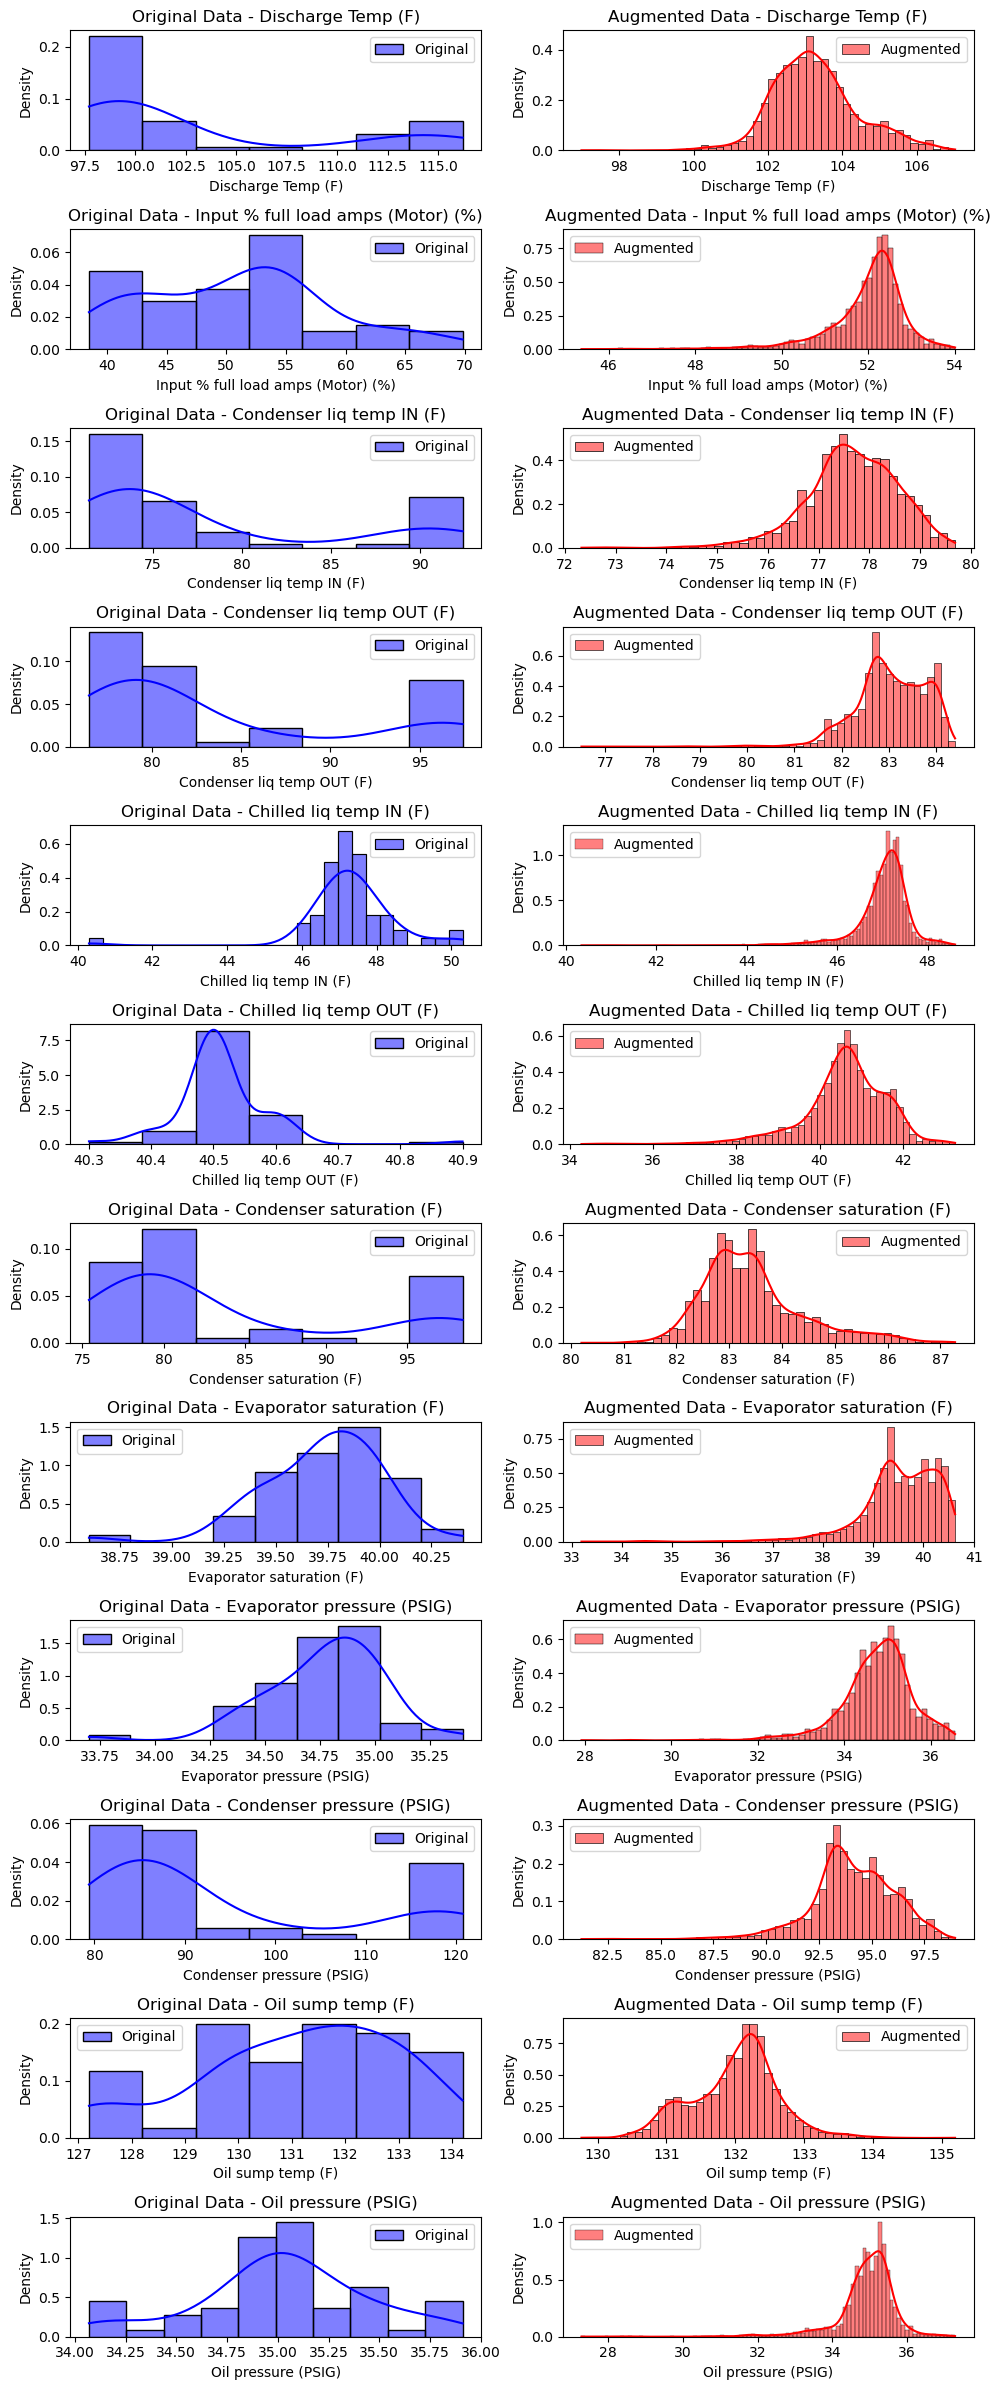

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of features in the dataset
num_features = len(data.columns)

# Plot KDE for original vs augmented data side by side
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(10, 2 * num_features))

for i, col in enumerate(data.columns):
    sns.histplot(data[col], kde=True, color='blue', ax=axes[i, 0], stat='density', label='Original')
    sns.histplot(augmented_data[col], kde=True, color='red', ax=axes[i, 1], stat='density', label='Augmented')
    axes[i, 0].set_title(f'Original Data - {col}')
    axes[i, 1].set_title(f'Augmented Data - {col}')
    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## Analysis and evaluation

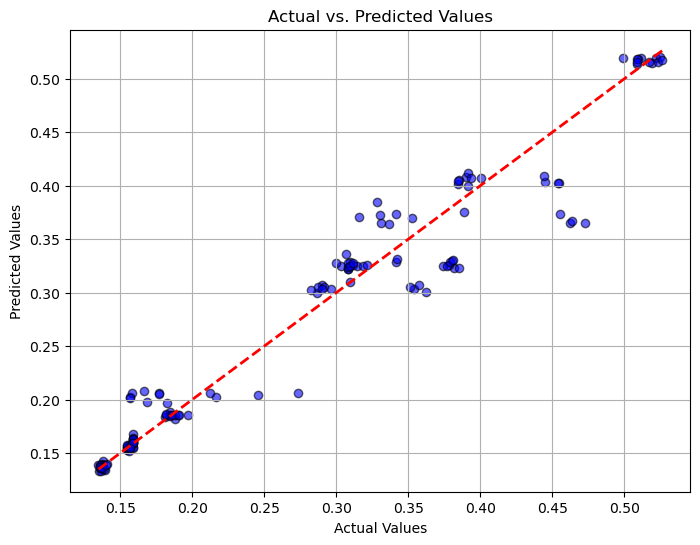

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure test_data and test_predictions are numpy arrays
test_data = np.array(test_data)
test_predictions = np.array(test_predictions)

# Corrected Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(test_data, test_predictions, alpha=0.6, color='blue', edgecolors='k')
# Use np.min() and np.max() for the plot range
plt.plot([np.min(test_data), np.max(test_data)], [np.min(test_data), np.max(test_data)], 
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

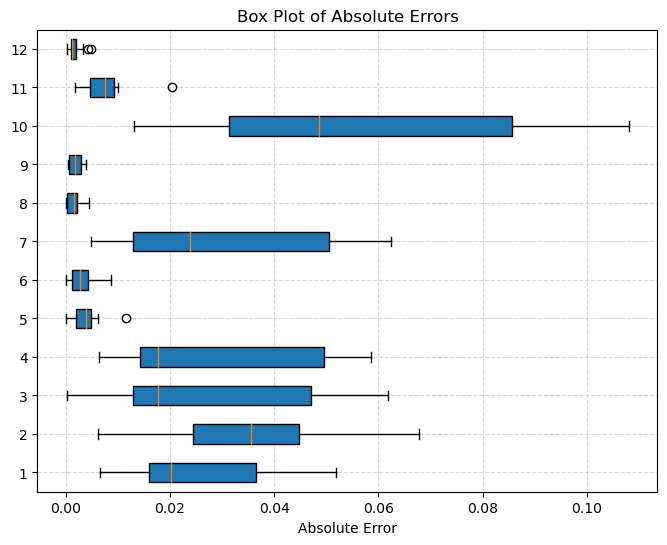

In [20]:
# Calculate absolute errors
absolute_errors = np.abs(test_data - test_predictions)

# Box plot of absolute errors
plt.figure(figsize=(8, 6))
plt.boxplot(absolute_errors, vert=False, patch_artist=True)
plt.xlabel('Absolute Error')
plt.title('Box Plot of Absolute Errors')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [24]:
from scipy.stats import wasserstein_distance

emd_results = {}
for column in data.columns:
    emd = wasserstein_distance(data[column], augmented_data[column])
    emd_results[column] = emd

emd_df = pd.DataFrame.from_dict(emd_results, orient='index', columns=['Wasserstein Distance'])
print("\nWasserstein Distance Results:\n", emd_df)


Wasserstein Distance Results:
                                     Wasserstein Distance
Discharge Temp (F)                              4.835821
Input % full load amps (Motor) (%)              5.636083
Condenser liq temp IN (F)                       5.363224
Condenser liq temp OUT (F)                      5.580859
Chilled liq temp IN (F)                         0.441450
Chilled liq temp OUT (F)                        0.711141
Condenser saturation (F)                        5.794094
Evaporator saturation (F)                       0.384718
Evaporator pressure (PSIG)                      0.417112
Condenser pressure (PSIG)                      10.799686
Oil sump temp (F)                               1.182519
Oil pressure (PSIG)                             0.218388


In [26]:
from scipy.spatial import distance

js_divergence_results = {}
for column in data.columns:
    p = data[column].value_counts(normalize=True, sort=False).values
    q = augmented_data[column].value_counts(normalize=True, sort=False).values
    min_length = min(len(p), len(q))
    js_divergence = distance.jensenshannon(p[:min_length], q[:min_length])
    js_divergence_results[column] = js_divergence

js_divergence_df = pd.DataFrame.from_dict(js_divergence_results, orient='index', columns=['Jensen-Shannon Divergence'])
print("\nJensen-Shannon Divergence Results:\n", js_divergence_df)


Jensen-Shannon Divergence Results:
                                     Jensen-Shannon Divergence
Discharge Temp (F)                                   0.193101
Input % full load amps (Motor) (%)                   0.093149
Condenser liq temp IN (F)                            0.153626
Condenser liq temp OUT (F)                           0.148507
Chilled liq temp IN (F)                              0.224207
Chilled liq temp OUT (F)                             0.421341
Condenser saturation (F)                             0.139205
Evaporator saturation (F)                            0.288891
Evaporator pressure (PSIG)                           0.274076
Condenser pressure (PSIG)                            0.087228
Oil sump temp (F)                                    0.172406
Oil pressure (PSIG)                                  0.114110


In [28]:
original_corr = data.corr()
augmented_corr = augmented_data.corr()
corr_diff = (original_corr - augmented_corr).abs().mean().mean()
print(f"\nAverage Absolute Difference in Correlation: {corr_diff}")



Average Absolute Difference in Correlation: 0.6014250406412837


In [30]:
    from scipy.stats import ttest_ind

    t_test_results = {}
    for column in data.columns:
        t_stat, p_value = ttest_ind(data[column], augmented_data[column])
        t_test_results[column] = {'t-statistic': t_stat, 'p-value': p_value}

    t_test_df = pd.DataFrame(t_test_results).T
    print("\nTwo-Sample t-Test Results:\n", t_test_df)


Two-Sample t-Test Results:
                                     t-statistic       p-value
Discharge Temp (F)                    -1.466799  1.425538e-01
Input % full load amps (Motor) (%)    -5.528471  3.557374e-08
Condenser liq temp IN (F)              1.709786  8.742665e-02
Condenser liq temp OUT (F)             3.536283  4.130116e-04
Chilled liq temp IN (F)                3.526510  4.284801e-04
Chilled liq temp OUT (F)              -0.714973  4.746912e-01
Condenser saturation (F)               2.211591  2.708305e-02
Evaporator saturation (F)              1.951427  5.111523e-02
Evaporator pressure (PSIG)             0.295224  7.678469e-01
Condenser pressure (PSIG)             -0.481955  6.298790e-01
Oil sump temp (F)                    -10.458588  4.260124e-25
Oil pressure (PSIG)                    1.147443  2.513058e-01
